## Masked Autoencoders: Visualization Roof3D
This is a visualization demo using our pre-trained MAE models. No GPU is needed.

In [45]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import models_mae
import urllib.request

### Define utils

In [3]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    #plt.imshow(torch.clip((image * 1 + 0) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir):
    from models_mae import mae_vit_base_patch16
    model=mae_vit_base_patch16()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    model.load_state_dict(checkpoint['model'], strict=False)
    print('MOdel loaded from', chkpt_dir)
    return model



def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

Image shape: (224, 224, 3)


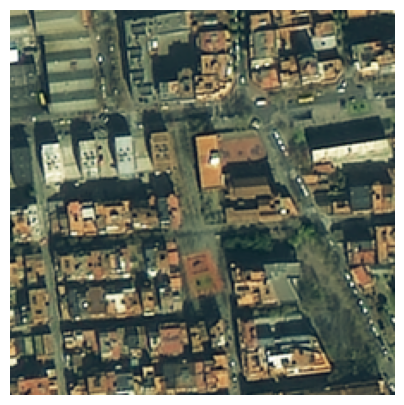

In [4]:
# load an image
#img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg'
#img_path = '/home/eras_tu/Documents/Dataset/Roof3D/ROOF3D/train/rgb/koeln_public4rgb.tif'
#img_path = '/home/eras_tu/Documents/Dataset/Roof3D/ROOF3D/train/rgb/koeln_public4rgb.tif'
img_path = '/home/eras_tu/Documents/Dataset/UBCV2/fine-grained_building_roof_instance_segmentation/images/train/1/GF2_Barcelona_41.4367_2.2029.tif'

img = Image.open(img_path)

img = img.resize((224, 224))

#assert img.shape == (224, 224, 3)

# Convert image from RGBA to RGB if necessary
if img.mode == 'RGBA':
    img = img.convert('RGB')

# Convert image to numpy array and normalize to [0, 1]
img = np.array(img) / 255.

# Check the shape of the image
print(f"Image shape: {img.shape}")


# Normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [5]:
# Define the checkpoint directory
chkpt_dir = '/home/eras_tu/Documents/mae_train_base_ubcv2/checkpoint-400.pth'
model = prepare_model(chkpt_dir)
print('Model loaded.')


MOdel loaded from /home/eras_tu/Documents/mae_train_base_ubcv2/checkpoint-400.pth
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


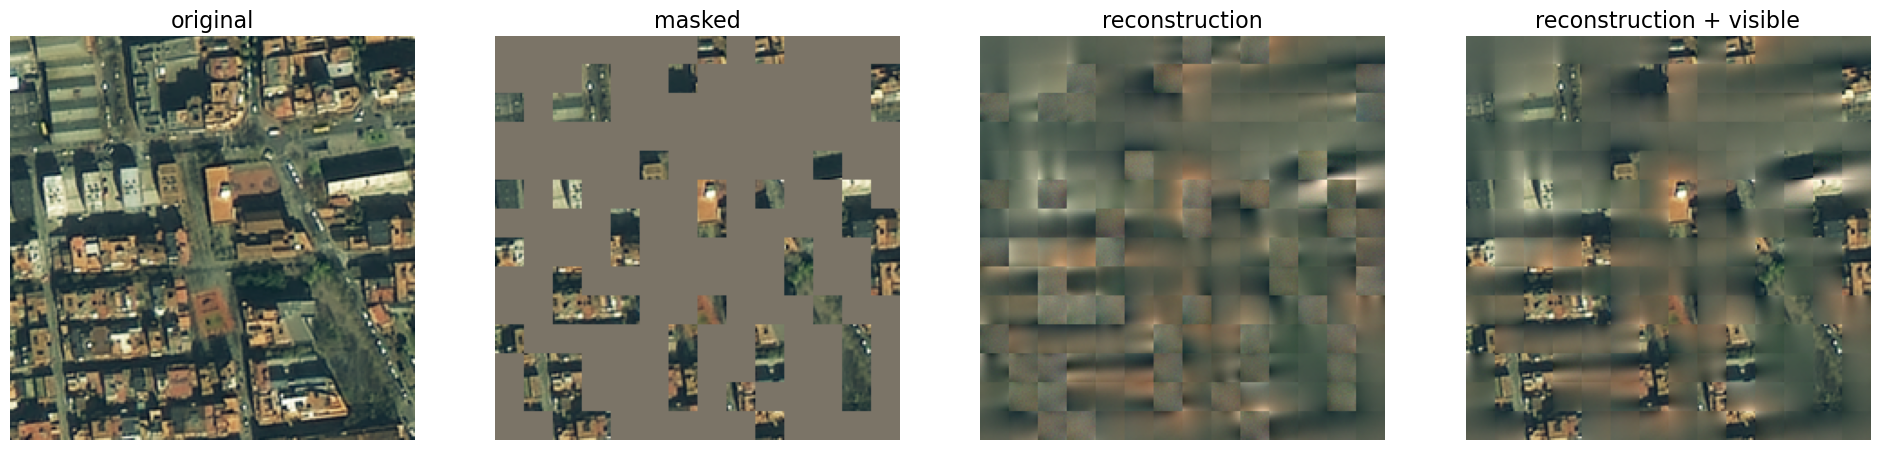

In [6]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model)

In [49]:
img.shape

(224, 224, 3)

In [37]:
img.min()

0.0

In [38]:
img.max()

1.0